# 0. Setup

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-9d5e4f83-3f58-2974-ee70-21df15226f84)


In [2]:
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import csv
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from misc.helpers import find_model_weights, calculate_label_distributions, prev_img, prev_img_gray, trans_norm2tensor, find_csv_files, get_image_paths_from_csv, get_image_paths_from_dir, create_vit_model
from misc.visualization import *
from scipy.stats import entropy
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from model.vit_for_small_dataset import ViT
from utils.imageQualityDataset import ImageQualityDataset
from utils.imageAttentionGlobalAvgDataset import ImageAttentionGlobalAvgDataset



# 1. Build Model

In [3]:
image_size=256
patch_size=16
num_classes=5
depth = 6

In [4]:
model = create_vit_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Load Dataset

In [5]:
csv_file = 'assets/Test/Obs0.csv'
dataset_root =  'assets/Test/DSX'
batch_size = 128

### 2.1 Add Augmentation (Transformation)

In [13]:
# Define the normalization parameters (mean and std)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the transformation including normalization
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

### 2.2 Loading

In [14]:
# Initialize dataset loader and test dataset
test_dataset = ImageQualityDataset(csv_file,dataset_root, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# model.to(device)

Number of images in class 0: 60
Number of images in class 1: 60
Number of images in class 2: 60
Number of images in class 3: 60
Number of images in class 4: 60

Number of images in the dataset: 300




In [15]:
image_path_to_check = 'assets/Test/DSX/45737ILSVRC2014_train_00060591.JPEG_I4_Q31.jpeg'
label = test_dataset.get_label_by_image_path(image_path_to_check)
print(f"The label for image '{os.path.basename(image_path_to_check)}' is: {label+1}")

The label for image '45737ILSVRC2014_train_00060591.JPEG_I4_Q31.jpeg' is: 4


# 3. Evaluate

### Evaluate single weight (AIO)

In [ ]:
# List of different weight files
weight_file = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO2.pth'
results = []
example_pred_results = []

print(f'Weights-file: {os.path.basename(weight_file)} will be evaluated')
# Load the model with different weights
model = create_vit_model(weights_path=weight_file)
model.eval()

# init result lists
true_labels = []
test_preds = []
entropies = []
true_entropies =[]
weighted_sums = []
kl_divs = []
with torch.no_grad():

    for i, (images, image_paths, labels) in enumerate(test_loader, 0):
        # images = images.to(device)
        # labels = labels.to(device)
        print(f"Example Prediction of Batch: {i}")
        outputs = model(images)
        true_labels.extend(labels)

        # Convert logits to probabilities
        probabilities = nn.functional.softmax(outputs, dim=1)
        
        # Calculate the true distribution
        true_distributions = calculate_label_distributions(labels,device='cpu')
        # Get predicition by the maximum probability
        _, preds = torch.max(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        
        formatted_probabilities = ["{:.4f}".format(prob) for prob in probabilities[0]]
        # print(f"Predicted Probabilities:{formatted_probabilities}")
        # print(f'Predicted Label: {preds[0]}')


        # Calculate Entropy
        entropy_values = entropy(probabilities.numpy(),base=np.exp(1), axis=1)
        true_entropy_values = entropy(true_distributions.numpy(),base=np.exp(1), axis=1)
        # Format entropies in a readble way
        entropies.extend(entropy_values)
        true_entropies.extend(entropy_values)
        # print(f'Mean Entropie of batch: {np.mean(entropy_values)}')

        # Calculate KL Divergence
        kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='batchmean')
        # print(f'KL-Divergence batchmean: {kl_div}')
        kl_divs.append(kl_div.item())
        
        # Define weighting factors
        weighting_factors = [0,1,2,3,4]
        # Calculate the weighted sum of probabilities
        weighted_sum = torch.sum(probabilities * torch.tensor(weighting_factors), dim=1).cpu().numpy()
        # Format weighted sum in a readble way
        weighted_sums.extend(weighted_sum)
        # Example printout for the first batch
        if i <=2:
            example_pred_result = {
                "Weights File": os.path.basename(weight_file),
                "Image Name": os.path.basename(image_paths[i]),
                "True Label": labels.cpu().numpy()[i],
                "Predicted Label": preds.cpu().numpy()[i],
                "Weighted Sum of Probability": weighted_sum[i],
                "True Probability Distribution": true_distributions[i].cpu().numpy().tolist(),
                "Predicted Probability Distribution": probabilities[i].cpu().numpy().tolist(),
                "Entropy Value": entropy_values[i],
                "True Entropy Value": true_entropy_values[i],
                "KL Divergence (batch-mean)": kl_divs[i],
            }
            example_pred_results.append(example_pred_result)
        print(f'True-Label: {labels.cpu()[0]}')
        print(f'Predicted-Label: {preds.cpu().numpy()[0]}')
        print(f'Weighted Sum of Probability: {round(weighted_sum[0],4)}')  # Weighted Sum of Prob
        print(f'Predicted Probality Distribution: {[round(prob,4) for prob in probabilities[0].numpy()]}')
        print(f'True Probality Distribution: {true_distributions.cpu().numpy()[0]}')
        print(f'Entropy Value: {round(entropy_values[0],4)}') # High Value: spreading; Low Value: concentrated
        print(f'True Entropy Value: {round(true_entropy_values[0],4)}') # High Value: spreading; Low Value: concentrated
        print(f'KL Divergence (batch-mean): {round(kl_div.item(),4)}\n')



# Calculate the MSE of weighted sum and ground truth
mse_weighted = mean_squared_error(true_labels, weighted_sums)

# Calculate the MSE of most likely class and ground truth
mse = mean_squared_error(true_labels, test_preds)

# Calculate the Mean Entropy
mean_entropy = np.mean(entropies)

# Calculate the Mean KL Divergence
mean_kl_div = np.mean(kl_divs)

# Calculate Accuracy
accuracy = accuracy_score(true_labels, test_preds)
target_names  = ["bad", "poor", "fair", "good", "excellent"]

# Generate classification report
class_report = classification_report(true_labels, test_preds, target_names=target_names)

# Generate confusion matrix
confusion = confusion_matrix(true_labels, test_preds)
print('#'*50)
print('model summary:')
# Save confusion matrix as a figure
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(weight_file.replace(".pth", "_confusion.png"))
plt.close()
result = {
    "Weights File": os.path.basename(weight_file),
    "Accuracy": accuracy,
    "MSE": mse,
    "MSE weighted": mse_weighted,
    "Mean Entropy": mean_entropy,
    "Mean KL Divergence": mean_kl_div, 
    "Classification Report": class_report
}
# Store the results
results.append(result)
# Print summary
for key, value in result.items():
    print(f"{key}: {value}")
print('#'*50)

# Create a DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_path = weight_file.replace(".pth", "_model_comparison_results.csv")
results_df.to_csv(results_path, index=False)

# Save example printouts to a CSV file for this model
example_printouts_df = pd.DataFrame(example_pred_results)
example_printout_file = weight_file.replace(".pth", "_model_comparison_results_examples.csv")
example_printouts_df.to_csv(example_printout_file, index=False)

### Cross comparison

In [ ]:
dataset_root = "assets/Test/DSX"
csv_dir = "assets/Test"
csv_files = [os.path.join(csv_dir, f'Obs{i}.csv') for i in range(1,6)]
weight_files = [f'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO{i}.pth'for i in range(6)]

print(csv_files)


In [ ]:
obs = []

for csv_file in csv_files:
    # Initialize dataset loader and test dataset
    test_dataset = ImageQualityDataset(csv_file,dataset_root, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print(f"loaded dataset due to {os.path.basename(csv_file)}")
    example_pred_results = []
    aio_acc = []

    for weight_file in weight_files:
        print(f'Weights-file: {os.path.basename(weight_file)} will be evaluated')
        # Load the model with different weights
        model.load_state_dict(torch.load(weight_file))
        model.eval()
        # aio_idx = int(''.join(filter(str.isdigit, os.path.basename(weight_file))))
        # init result lists
        true_labels = []
        test_preds = []

        with torch.no_grad():
            for i, (images,image_paths, labels) in enumerate(test_loader, 0):
                # images = images.to(device)
                # labels = labels.to(device)
                print(f"Example Prediction of Batch: {i}")
                outputs = model(images)
                true_labels.extend(labels)

                # Convert logits to probabilities
                probabilities = nn.functional.softmax(outputs, dim=1)
                 
                if i != 0:
                    true_distributions = calculate_label_distributions(labels,device='cpu')
                else:
                    true_distributions = torch.nn.functional.one_hot(labels, num_classes).float()

                # Get predicition by the maximum probability
                _, preds = torch.max(outputs, dim=1)
                test_preds.extend(preds.cpu().numpy())

                print(f'Image Name: {os.path.basename(image_paths[i])}')
                print(f'True-Label: {labels.cpu()[0]}')
                print(f'Predicted-Label: {preds.cpu().numpy()[0]}')
                print(f'Predicted Probality Distribution: {[round(prob,4) for prob in probabilities[0].numpy()]}')
                print(f'True Probality Distribution: {true_distributions.cpu().numpy()[0]}')


        # Calculate Accuracy
        accuracy = accuracy_score(true_labels, test_preds)

        print('\n')
        print('#'*50)
        print('model summary:')
        result = {
            "Weights File": os.path.basename(weight_file),
            "Accuracy (accaptable)": round(accuracy,2),
        }
        aio_acc.append(accuracy)
        # Print summary
        for key, value in result.items():
            print(f"{key}: {value}")
        print('#'*50)
        print('\n')

        target_names  = ["bad", "poor", "fair", "good", "excellent"]
        # Generate confusion matrix
        confusion = confusion_matrix(true_labels, test_preds)
        
        # Create a DataFrame from the confusion matrix with target names
        # confusion_df = pd.DataFrame(confusion, index=target_names, columns=target_names)

        # Ensure the confusion matrix has the correct shape (5x5 in this case)
        expected_shape = (len(target_names), len(target_names))

        # Create a DataFrame with zeros and the correct shape
        confusion_df = pd.DataFrame(0, index=target_names, columns=target_names)

        # Update the DataFrame with the values from the provided confusion matrix
        confusion_df.loc[confusion_df.index[:len(confusion)], confusion_df.columns[:len(confusion)]] = confusion



        obs_name, _ = os.path.splitext(os.path.basename(csv_file))
        confusion_path = weight_file.replace(".pth", f"_{obs_name}_confusion.png")
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.savefig(confusion_path)
        plt.close()

    obs.append(aio_acc)


# Create a DataFrame for the obs list with proper headers and index (cross comparison)
cc_df = pd.DataFrame(obs, columns=[f"AIO{i}" for i in range(6)], index=[f"Obs{i}" for i in range(6)])

# Specify the path to save the obs table as a CSV file
cc_path = os.path.join(os.path.dirname(weight_files[0]),"cross_comparison.csv")

# Save the DataFrame to a CSV file
cc_df.to_csv(cc_path)

#### Acceptable Ratio Table

In [ ]:
directory_path = "assets/Test"
csv_files = [f'assets/Test/Obs{i}.csv'for i in range(6)]
# List of weight files
weights_dir = "results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL"
weight_files = [f'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO{i}.pth'for i in range(6)]


In [ ]:
obs = [[] for _ in range(len(csv_files))]
for csv_file in csv_files:
    # Initialize dataset loader and test dataset
    test_dataset = ImageQualityDataset(csv_file,dataset_root, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    obs_idx = int(''.join(filter(str.isdigit, csv_file)))-1
    example_pred_results = []
    aio_acc = [0] * len(weight_files)

    for weight_file in weight_files:
        print(f'Weights-file: {os.path.basename(weight_file)} will be evaluated')
        # Load the model with different weights
        model.load_state_dict(torch.load(weight_file))
        model.eval()
        aio_idx = int(''.join(filter(str.isdigit, os.path.basename(weight_file))))-1
        # init result lists
        true_labels = []
        test_preds = []

        with torch.no_grad():
            for i, (images,image_paths, labels) in enumerate(test_loader, 0):
                # images = images.to(device)
                # labels = labels.to(device)
                print(f"Example Prediction of Batch: {i}")
                outputs = model(images)
                true_labels.extend(labels)

                # Convert logits to probabilities
                probabilities = nn.functional.softmax(outputs, dim=1)
                 
                if obs_idx != 0 and aio_idx !=0 or obs_idx != 0:
                    # Calculate the true distribution
                    true_distributions = calculate_label_distributions(labels,device='cpu')
                else:
                    true_distributions = torch.nn.functional.one_hot(labels, num_classes).float()

                # Get predicition by the maximum probability
                _, preds = torch.max(outputs, dim=1)
                test_preds.extend(preds.cpu().numpy())

                print(f'Image Name: {os.path.basename(image_paths[i])}')
                print(f'True-Label: {labels.cpu()[0]}')
                print(f'Predicted-Label: {preds.cpu().numpy()[0]}')
                print(f'Predicted Probality Distribution: {[round(prob,4) for prob in probabilities[0].numpy()]}')
                print(f'True Probality Distribution: {true_distributions.cpu().numpy()[0]}')


        # Calculate Accuracy
        # accuracy = accuracy_score(true_labels, test_preds)
        correct_predictions = sum(1 for true, pred in zip(true_labels, test_preds) if true == pred or abs(true - pred) == 1)
        total_predictions = len(true_labels)
        accuracy = correct_predictions / total_predictions
        print('\n')
        print('#'*50)
        print('model summary:')
        result = {
            "Weights File": os.path.basename(weight_file),
            "Accuracy (accaptable)": round(accuracy,2),
        }
        aio_acc[aio_idx]=accuracy
        # Print summary
        for key, value in result.items():
            print(f"{key}: {value}")
        print('#'*50)
        print('\n')
    obs[obs_idx]=aio_acc


# Create a DataFrame for the obs list with proper headers and index
obs_df = pd.DataFrame(obs, columns=[f"AIO{i}" for i in range(1,6)], index=[f"Obs{i}" for i in range(1,6)])

# Specify the path to save the obs table as a CSV file
obs_path = os.path.join(weights_dir,"cross_comparison_acceptable_ratio.csv")

# Save the DataFrame to a CSV file
obs_df.to_csv(obs_path)

# 4. Plot

### Plot Distributions

In [6]:
model = create_vit_model()
batch_size = 128

weights_dir = "results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL"
# List of different weight files
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1,6)]

# dir with images
images_dir = "assets/Test/DSX"

# image_paths = get_image_paths_from_dir(images_dir)
# image_paths = get_image_paths_from_csv('assets/Test/DSX/global_avg.csv', 5)

# select images manually
filenames = ['8034ILSVRC2013_train_00034320.JPEG_I4_Q50.jpeg', '10451ILSVRC2013_train_00058547.JPEG_I1_Q2.jpeg', '4692ILSVRC2013_train_00079353.JPEG_I3_Q22.jpeg', '30442ILSVRC2014_train_00005639.JPEG_I1_Q3.jpeg', '4337ILSVRC2013_train_00018603.JPEG_I1_Q8.jpeg']
image_paths = [os.path.join(images_dir, filename) for filename in filenames]

print(weight_files)
print(image_paths)


['results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO1.pth', 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO2.pth', 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO3.pth', 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO4.pth', 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO5.pth']
['assets/Test/DSX/8034ILSVRC2013_train_00034320.JPEG_I4_Q50.jpeg', 'assets/Test/DSX/10451ILSVRC2013_train_00058547.JPEG_I1_Q2.jpeg', 'assets/Test/DSX/4692ILSVRC2013_train_00079353.JPEG_I3_Q22.jpeg', 'assets/Test/DSX/30442ILSVRC2014_train_00005639.JPEG_I1_Q3.jpeg', 'assets/Test/DSX/4337ILSVRC2013_train_00018603.JPEG_I1_Q8.jpeg']


#### True Distribution

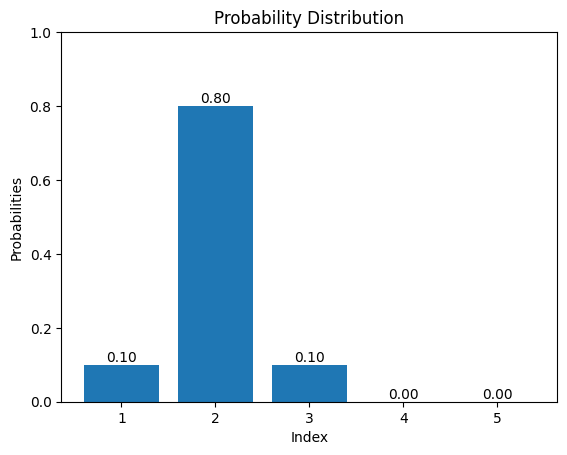

In [7]:
true_distribution = calculate_label_distributions([1],device=device).cpu().numpy()[0]
# Create an index for the x-axis
index = range(1, len(true_distribution) + 1)

# Plot the probability distribution
plt.bar(index, true_distribution, tick_label=index)
plt.ylim(0,1)
plt.xlabel('Index')
plt.ylabel('Probabilities')
# Add text labels for each bar
for i in range(len(true_distribution)):
    plt.text(index[i], true_distribution[i], f'{true_distribution[i]:.2f}', ha='center', va='bottom')
plt.title('Probability Distribution')
plt.savefig('Probability Distribution.png')
plt.show()

#### Predicted Distribution

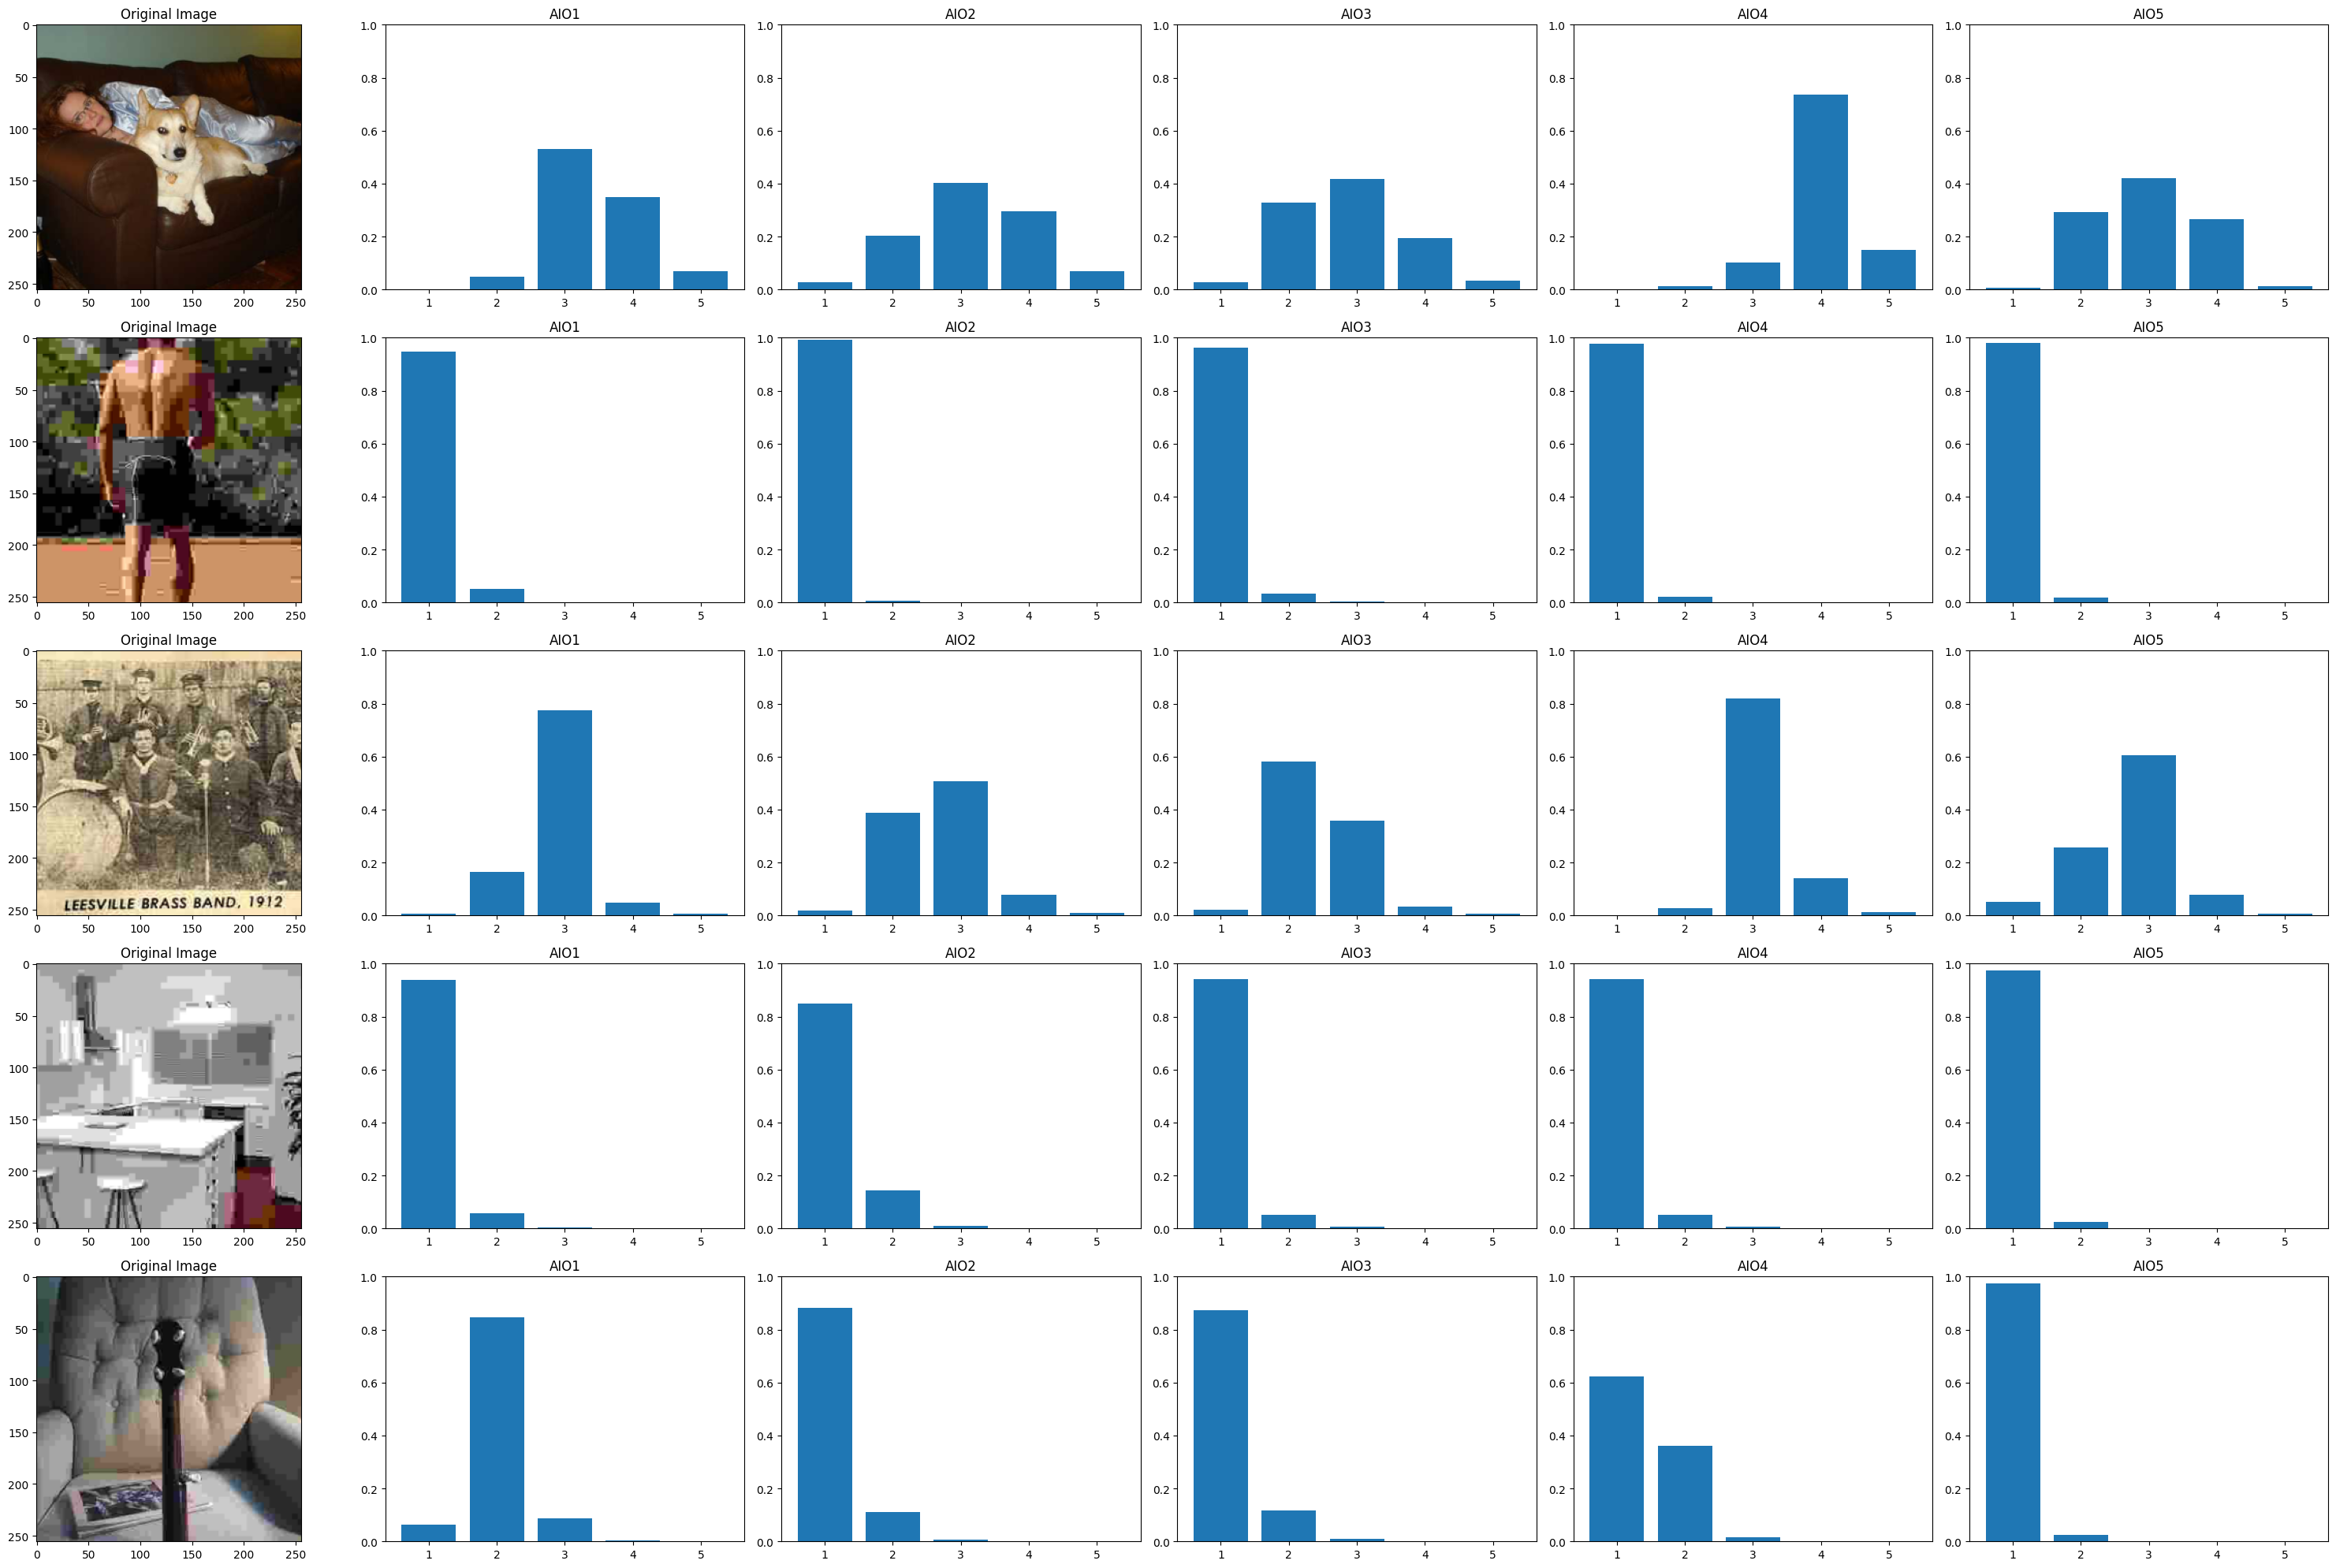

In [8]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


# Init Matplotlib-Fig
num_weights = len(weight_files)
num_images = len(image_paths)
fig, axes = plt.subplots(num_images, num_weights+1, figsize=(30, 20))

for i in range(len(weight_files)+1):
    if i != 0:
        model.load_state_dict(torch.load(weight_files[i-1]))

    for j, image_path in enumerate(image_paths):
        ax = axes[j,i]
        image = Image.open(image_path)

        if i == 0:  # Only the first column should have images
            # Load the image and display it on the y-axis
            img = prev_img(image, image_size)
            ax.imshow(img)
            ax.set_title('Original Image')
        else:
            img_tensor = trans_norm2tensor(image,image_size)
            img = img_tensor.unsqueeze(0).to(device)
            model.to(device)
            with torch.no_grad():
                model.eval()
                output= model(img)

            probabilities = torch.softmax(output, dim=1).cpu().numpy()[0]            # Adjust x-axis values
            x = np.arange(1, len(probabilities) + 1)
            ax.bar(x, probabilities)
            ax.set_title(f'{os.path.splitext(os.path.basename(weight_files[i-1]))[0]}')
            # Set Y-scale from 1 to 0
            ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


#### Compare

In [ ]:
def standard_deviation(probabilities, num_classes=5):
    """
    Calculate the standard deviation of a distribution represented by probabilities.

    This function computes the standard deviation of a distribution given a list of probabilities
    for each class. It assumes that the probabilities are indexed by class label, starting from 1
    up to the specified number of classes.

    Parameters:
        probabilities (list): A list of probabilities for each class.
        num_classes (int): The total number of classes. Defaults to 5.

    Returns:
        float: The standard deviation of the distribution.

    """
    # Check if the number of probabilities matches the number of classes
    if len(probabilities) != num_classes:
        raise ValueError("Number of probabilities and classes should be the same.")

    # Convert lists to PyTorch tensors
    probabilities_tensor = torch.tensor(probabilities, dtype=torch.float32)
    values_tensor = torch.arange(1, num_classes + 1)

    # Calculate the mean (expectation) of the distribution
    mean = torch.sum(probabilities_tensor * values_tensor)

    # Calculate the squared difference of each value from the mean
    squared_diff = (values_tensor - mean) ** 2

    # Calculate the weighted sum of squared differences
    weighted_sum = torch.sum(probabilities_tensor * squared_diff)

    # Calculate the standard deviation as the square root of the weighted sum
    std_deviation = torch.sqrt(weighted_sum)

    return std_deviation.item()


In [ ]:
def compare_probabilities(label, predicted_probabilities, ax):
    """
    Compare predicted probabilities with true distribution for a given label.

    This function visualizes the predicted probabilities and the true distribution
    for a given label using a bar chart. The predicted probabilities are plotted
    in orange, while the true distribution is plotted in black.

    Parameters:
        label (int): The true label for comparison.
        predicted_probabilities (list or numpy.ndarray): Predicted probabilities for each class.
        ax (matplotlib.axes.Axes): The matplotlib axes object for plotting.

    Returns:
        None
    """
    # Calculate the true distribution for the given label
    true_distribution = calculate_label_distributions(label, device=device)
    true_distribution = true_distribution.cpu().numpy()[0]

    # Set the offset for better visualization
    offset = 0.35

    # Plot the predicted probabilities and true distribution as bar charts
    ax.bar(np.arange(len(predicted_probabilities)), predicted_probabilities, width=0.35, label='predicted', align='center', color='orange')
    ax.bar(np.arange(len(true_distribution)) + offset, true_distribution, width=0.35, label='true', align='center', color='black')

    # Set plot limits, labels, and ticks
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('Class')
    ax.set_ylabel('Probability')
    ax.set_xticks(np.arange(len(true_distribution)) + offset/2)
    ax.set_xticklabels(np.arange(len(true_distribution)))
    ax.legend()


In [ ]:
csv_dir = 'assets/Test'
csv_files = [os.path.join(csv_dir, f'Obs{i}.csv') for i in range(1,6)]
dataset_root = 'assets/Test/DSX'
num_weights = len(weight_files)
num_images = len(image_paths)
fig, axes = plt.subplots(num_images, num_weights+1, figsize=(4.5 * num_weights+1, 3 * num_images))

for i in range(len(weight_files)+1):
    if i != 0:
        model.load_state_dict(torch.load(weight_files[i-1]))
        dataset = ImageQualityDataset(csv_files[i-1], dataset_root, transform=transform)
    for j, image_path in enumerate(image_paths):
        ax = axes[j,i]
        image = Image.open(image_path)

        if i == 0:  # Only the first column should have images
            # Load the image and display it on the y-axis
            img = prev_img(image, image_size)
            ax.imshow(img)
            ax.set_title('Original Image')
            ax.axis('off')
        else:
            img_tensor = trans_norm2tensor(image,image_size)
            img = img_tensor.unsqueeze(0).to(device)
            model.to(device)
            with torch.no_grad():
                model.eval()
                output= model(img)

            label = dataset.get_label_by_image_path(os.path.join(dataset_root, os.path.basename(image_path)))
            label_tensor = torch.tensor(label).unsqueeze(0).cpu().numpy()

            probabilities = torch.softmax(output, dim=1)
            std_deviation_result = standard_deviation(probabilities[0].cpu().numpy())
            print(f"Standard deviation for image {j+1} and AIO {i}: {std_deviation_result}")
            compare_probabilities(label_tensor, probabilities[0].cpu().numpy(), ax)
            ax.set_title(f'{os.path.splitext(os.path.basename(weight_files[i-1]))[0]}')

plt.tight_layout()
plt.show()

### Plot Attention

In [9]:
image_size = 256
depth = 6
num_classes = 5
patch_size = 16

model = create_vit_model()
print(model)

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((3840,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3840, out_features=1024, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (

#### Plot Attention Map of Single AIO

In [16]:
weight_file = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO5.pth'
# image_path = 'assets/work_imgs/fg_bg/18387ILSVRC2013_train_00086939.JPEG_I5_Q60.jpeg'
image_path = image_path_to_check
layer_idx = 5

(6, 16, 256, 256)
(16, 256, 256)


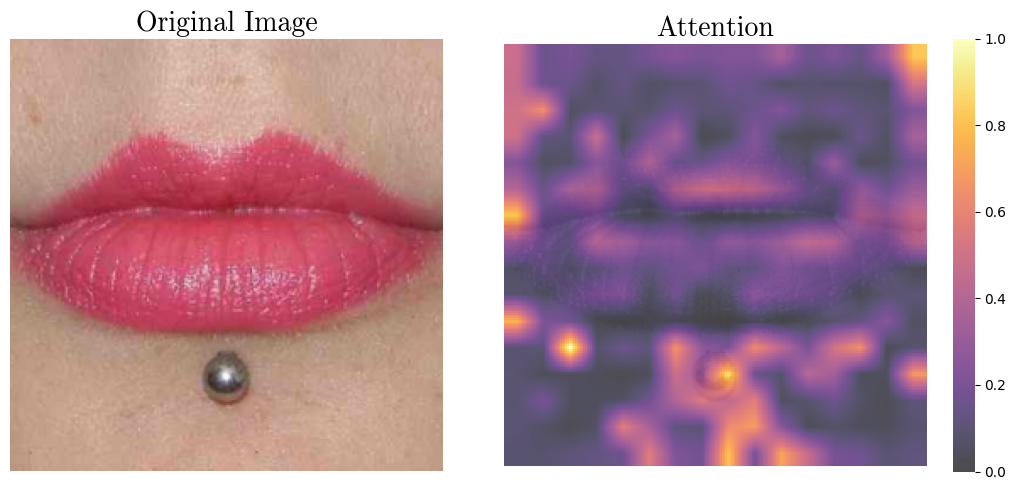

In [17]:

model = create_vit_model(weights_path=weight_file)
model.eval()
image = Image.open(image_path)
img_pre = trans_norm2tensor(image, image_size)
_, attention = get_attention_maps(model, img_pre, patch_size, device)
print(attention.shape)
n_heads = attention.shape[1]
n_layers = attention.shape[0]

img_pre = prev_img(image, image_size)
img_gray = prev_img_gray(image, image_size)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))  # Create subplots

for ax in axes.flat:
    ax.axis('off')

# Plot the original image
axes[0].imshow(img_pre)
axes[0].set_title("Original Image", fontsize=20, fontname='cmr10')

# Plot the grayscale image with heatmap overlay for Median
layer_attention = attention[layer_idx]
print(layer_attention.shape)

layer_mean = np.mean(layer_attention, axis=0)
layer_mean_norm = normalize_attention_maps(layer_mean)

heatmap = sns.heatmap(layer_mean_norm, cmap="inferno", alpha=0.7, ax=axes[1])
axes[1].imshow(img_gray, cmap='gray', alpha=0.5)
axes[1].set_title("Attention", fontsize=20, fontname='cmr10')
plt.tight_layout()
plt.show()

#### Plot Attention across all layers and all heads (no comparison)

Single AIO

In [ ]:
weight_file = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL/AIO0.pth'
image_path = 'assets/work_imgs/focus/637ILSVRC2013_train_00009458.JPEG_I4_Q37.jpeg'

model = create_vit_model(weights_path=weight_file)
model.eval()
image = Image.open(image_path)
visualize_all_layer_head_attention_maps(model, image, image_size, patch_size, device)

Multiple AIOs

In [ ]:
image_path = 'assets/work_imgs/focus/637ILSVRC2013_train_00009458.JPEG_I4_Q37.jpeg'
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(0, 6)]

for weight_file in weight_files:
    model = create_vit_model(weights_path=weight_file)
    model.eval()
    image = Image.open(image_path)
    visualize_all_layer_head_attention_maps(model, image, image_size, patch_size, device)

#### Plot Attention across specific layer (comparison)

In [ ]:
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(6)]

images_dir = 'assets/work_imgs/fg_bg'
image_paths = get_image_paths_from_dir(images_dir)

output_dir = 'results/Attention_maps/comparisons'

layer_idx = -1

plot_attention_maps_comparison(weight_files,image_paths, image_size, patch_size,output_dir, layer_idx,device)

#### Plot mean head of all layers for every AIO (compare layers)

No sub

In [ ]:
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(6)]
images_dir = 'assets/work_imgs/blurry'
image_paths = get_image_paths_from_dir(images_dir)

for image_path in image_paths:
    image = Image.open(image_path)
    get_attention_maps_across_weights(model, image, image_size, patch_size, depth, weight_files, device)

Sub avg (in comparison)

In [ ]:
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1,6)]
images_dir = 'assets/work_imgs/focus'
num_files = 5
image_paths = get_image_paths_from_dir(images_dir,num_files)
depth = 6

csv_file_path = 'assets/Test/DSX/global_avg.csv'
# image_paths = get_image_paths_from_csv(csv_file_path, num_files)
for image_path in image_paths:
    img = Image.open(image_path)
    get_attention_maps_with_deviation(img, weight_files, image_size,depth, patch_size, device)

#### Plot Attention of Images sorted by global avg

Load Dataset to get global average

In [ ]:
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
images_dir = 'assets/Test/DSX'
# List of different weight files
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1, 6)]
layer_idx = -1

# Create a DataLoader
global_avg_dataset = ImageAttentionGlobalAvgDataset(images_dir, weight_files, image_size, patch_size, layer_idx, device)

Write for each image the global avg and path to a csv file 

In [ ]:
csv_file_path = os.path.join(images_dir, 'global_avg.csv')

global_avg_dataset.write_to_csv(csv_file_path)

Get the top 5 images with the highest difference

In [ ]:
# print(f"test: {global_avg_dataset[0]}")
top_5 = global_avg_dataset.get_top_global_avg(5,True)
# print(f"Global Avg: {top_5}")
for i in range(len(top_5)):
    fieldnames = ['filename', 'global_avg'] 
    selected_fields = {key: top_5[i][key] for key in fieldnames}
    print(selected_fields)

Get the top 5 images with the lowest difference

In [ ]:
top_5_neg = global_avg_dataset.get_top_global_avg(5,False)

for i in range(len(top_5_neg)):
    fieldnames = ['filename', 'global_avg'] 
    selected_fields = {key: top_5_neg[i][key] for key in fieldnames}
    print(selected_fields)

Plot attention of images with highest global avg

In [ ]:
output_dir = 'results/Attention_maps/comparisons'
weights_dir = '/home/maxgan/WORKSPACE/UNI/BA/vision-transformer-for-image-quality-perception-of-individual-observers/results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
images_dir = 'assets/Test/DSX'
# List of different weight files
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1, 6)]
layer_idx = -1

image_paths = []

for i in range(len(top_5)):
    filename = top_5[i]['filename']
    global_avg = top_5[i]['global_avg']
    image_paths.append(os.path.join(images_dir,filename))
    print(f"{filename} has a global average of {global_avg}")

filenames = ['8034ILSVRC2013_train_00034320.JPEG_I4_Q50.jpeg', '10451ILSVRC2013_train_00058547.JPEG_I1_Q2.jpeg', '4692ILSVRC2013_train_00079353.JPEG_I3_Q22.jpeg', '30442ILSVRC2014_train_00005639.JPEG_I1_Q3.jpeg', '4337ILSVRC2013_train_00018603.JPEG_I1_Q8.jpeg']
# image_paths = [os.path.join(images_dir, filename) for filename in filenames]
plot_attention_maps_comparison(weight_files, image_paths, image_size, patch_size,output_dir, layer_idx, device)

Plot attention of images with lowest global avg

In [ ]:
output_dir = 'results/Attention_maps/comparisons'
weights_dir = 'results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL'
# List of different weight files
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1, 6)]
layer_idx = 5

# csv_file_path = 'assets/work_imgs/fg_bg/global_avg.csv'
# image_paths = get_image_paths_from_csv(csv0_file_path, num_files)
# num_files = 5
image_paths = []

for i in range(len(top_5_neg)):
    filename = top_5_neg[i]['filename']
    global_avg = top_5_neg[i]['global_avg']
    image_paths.append(os.path.join(images_dir,filename))
    print(f"{filename} has a global average of {global_avg}")
plot_attention_maps_comparison(weight_files, image_paths, image_size, patch_size,output_dir, layer_idx, device)